In [ ]:
import re

In [ ]:
modelled_freq='30min'

In [ ]:
freq_time = (re.findall(r'(\d+)(\w+)', modelled_freq)[0][0])

In [ ]:
int(freq_time)

In [ ]:
re?

In [1]:
cd ..

/home/jovyan/dea_intertidal/dea-intertidal


In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import re
from math import ceil

from numpy import interp
from scipy.signal import argrelmax, argrelmin

from intertidal.utils import (
    round_date_strings,
    intertidal_hillshade,
)
from intertidal.tide_modelling import pixel_tides_ensemble

In [44]:
%store -r ds

In [45]:
dem = ds.elevation

In [5]:
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

In [6]:
time_range = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

In [7]:
calculate_quantiles = np.linspace(0, 1, 101) #nb formerly 'pc_range'

In [46]:
ModelledTides, _ = pixel_tides_ensemble(
    dem,
    # calculate_quantiles=calculate_quantiles,
    times=time_range,
    directory=tide_model_dir,
    ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
    top_n=3,
    reduce_method='mean',
    resolution=3000,
)

Running ensemble tide modelling
Creating reduced resolution 3000 x 3000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


  3%|▎         | 1/35 [00:26<15:03, 26.57s/it]

Returning low resolution tide array
Generating ensemble tide model from point inputs
Interpolating model weights using 'idw' interpolation
                 weights
tide_model              
FES2014         0.402385
TPXO9-atlas-v5  0.400415
EOT20           0.399260
TPXO8-atlas-v1  0.395403
FES2012         0.392284
GOT4.10         0.372850
HAMTIDE11       0.127742
Reducing multiple models into single ensemble model using 'mean'
Reprojecting ensemble tides into original array


In [ ]:
# ModelledTides

In [9]:
# ## For use with spatial filter options
# ## stack the y and x dimensions
# stacked_everything = ModelledTides.stack(z=['y','x']).groupby('z')
# stacked_everything

DataArrayGroupBy, grouped over 'z'
598775 groups with labels (-3794665.0,, 580015.0), ..., ....

In [ ]:
# ModelledTides.mean(dim=["x","y"])

In [11]:
# Extract the modelling freq units
# Split the number and text characters in modelled_freq
freq_time = int(re.findall(r'(\d+)(\w+)', modelled_freq)[0][0])
freq_unit = str(re.findall(r'(\d+)(\w+)', modelled_freq)[0][-1])

# Extract the number of modelled timesteps per 14 days (half lunar cycle) for neap/spring calcs
mod_timesteps = pd.Timedelta((29.5/2),"d")/pd.Timedelta(freq_time, freq_unit)

## Identify kwargs for peak detection algorithm
order=(int(mod_timesteps/2))

In [47]:
tide_cq_dict={}
exposure={}
timeranges={}

In [48]:
stacked_everything = ModelledTides.mean(dim=["x","y"])
stacked_everything

<xarray.DataArray 'tide_m' (time: 8761)>
array([ 0.37810886, -0.768233  , -0.56757313, ..., -0.15731664,
        0.23607086,  0.22522296], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 ... 2022-12-31
    spatial_ref  int32 3577

In [29]:
filters =['Neap_high']

# if x == 'Spring_high' or x == 'Spring_low':
for x in filters:
    if x in ['Spring_high', 'Spring_low', 'Neap_high', 'Neap_low']:

        print (f'Calculating {x}')

        #1D tide modelling workflow

        ## apply the peak detection routine
        if x in ['Spring_high', 'Neap_high']:
            stacked_everything_peaks = argrelmax(stacked_everything.values, order=order)[0]
        if x in ['Spring_low', 'Neap_low']:
            stacked_everything_peaks = argrelmin(stacked_everything.values, order=order)[0]
        if x == 'Neap_high':       
            ## apply the peak detection routine to calculate all the high tide maxima
            Max_testarray = argrelmax(stacked_everything.values)[0]
            
            Max_testarray = stacked_everything.isel(time=Max_testarray)
            ## extract all hightide peaks
            Max_testarray = ModelledTides.to_dataset().sel(time=Max_testarray.time)
            ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
            stacked_everything2 = Max_testarray.mean(dim=["x","y"])
            ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
            ## relative to the number of spring high tide values
            order_nh = int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
            ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
            neap_peaks = argrelmin(stacked_everything2.tide_m.values, order=order_nh)[0] 

        if x == 'Neap_low':       
            ## apply the peak detection routine to calculate all the high tide maxima
            Max_testarray = argrelmin(stacked_everything.values)[0]
            
            Max_testarray = stacked_everything.isel(time=Max_testarray)
            ## extract all hightide peaks
            Max_testarray = ModelledTides.to_dataset().sel(time=Max_testarray.time)
            ## repeat the peak detection to identify neap high tides (maxima in the low tide minima)
            stacked_everything2 = Max_testarray.mean(dim=["x","y"])
            ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
            ## relative to the number of spring high tide values
            order_nh = int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
            ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
            neap_peaks = argrelmax(stacked_everything2.tide_m.values, order=order_nh)[0]

        if x in ['Neap_high', 'Neap_low']: 
            ## extract neap high tides
            neappeaks = Max_testarray.isel(time=neap_peaks)

            timeranges[str(x)]=pd.to_datetime(neappeaks.time)

            # Extract the peak height dates
            tide_cq = neappeaks.quantile(q=calculate_quantiles,dim='time')


        if x in ['Spring_high', 'Spring_low']:  
            # select for indices associated with peaks
            springpeaks = stacked_everything.isel(time=stacked_everything_peaks)

            # Select dates associated with detected peaks
            springpeaks = ModelledTides.to_dataset().sel(time=springpeaks.time)

            # Save datetimes for calculation of combined filter exposure
            timeranges[str(x)]=pd.to_datetime(springpeaks.time)

            # Extract the peak height dates
            tide_cq = springpeaks.quantile(q=calculate_quantiles,dim='time')

        # Add tide_cq to output dict
        tide_cq_dict[str(x)]=tide_cq.tide_m

        # Calculate the tide-height difference between the elevation value and
        # each percentile value per pixel
        diff = abs(tide_cq.tide_m - dem)

        # Take the percentile of the smallest tide-height difference as the
        # exposure % per pixel
        idxmin = diff.idxmin(dim="quantile")

        # Convert to percentage
        exposure[str(x)] = idxmin * 100 
    


Calculating Neap_high


In [19]:
tide_cq_dict

{'Neap_low': <xarray.Dataset>
 Dimensions:   (y: 557, x: 1075, quantile: 101)
 Coordinates:
   * y         (y) float64 -3.795e+06 -3.795e+06 -3.795e+06 ... -3.8e+06 -3.8e+06
   * x         (x) float64 5.8e+05 5.8e+05 5.8e+05 ... 5.907e+05 5.908e+05
   * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
 Data variables:
     tide_m    (quantile, y, x) float64 -0.2257 -0.2257 -0.2257 ... 0.2349 0.2349}

In [18]:
tide_cq

<xarray.Dataset>
Dimensions:   (y: 557, x: 1075, quantile: 101)
Coordinates:
  * y         (y) float64 -3.795e+06 -3.795e+06 -3.795e+06 ... -3.8e+06 -3.8e+06
  * x         (x) float64 5.8e+05 5.8e+05 5.8e+05 ... 5.907e+05 5.908e+05
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
Data variables:
    tide_m    (quantile, y, x) float64 -0.2257 -0.2257 -0.2257 ... 0.2349 0.2349

In [ ]:
# exposure['Neap_high'].plot()
int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
# len(stacked_everything_peaks)
# len(Max_testarray.time)
# stacked_everything.isel(time=Max_testarray)
# order

testc = argrelmax(stacked_everything2.tide_m.values, order=order_nh)[0] #order_nh

stacked_everything2.tide_m[0:340].plot(marker='o')
Max_testarray.tide_m.isel(time=testc).mean(dim=["x","y"])[0:16].plot(marker='o',color='red')


In [ ]:
testb = stacked_everything.isel(time=argrelmin(stacked_everything.values)[0])

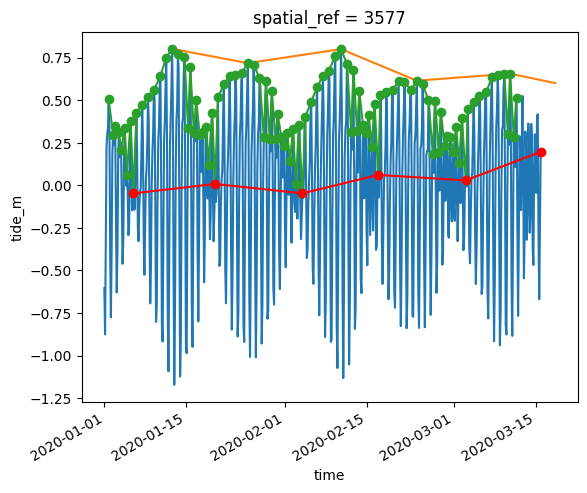

In [30]:
stacked_everything[0:600].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:6].plot()
stacked_everything2.tide_m[0:100].plot(marker='o')
# testb[0:100].plot(marker='o')
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neap_peaks).mean(dim=["x","y"])[0:6].plot(marker='o',color='red')
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

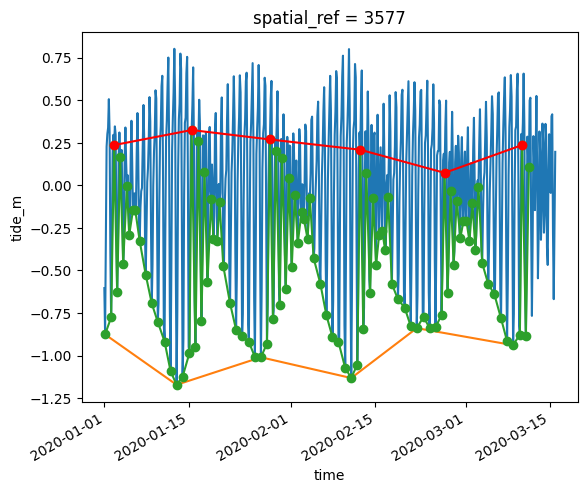

In [28]:
stacked_everything[0:600].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:6].plot()
stacked_everything2.tide_m[0:100].plot(marker='o')
# testb[0:100].plot(marker='o')
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neap_peaks).mean(dim=["x","y"])[0:6].plot(marker='o',color='red')
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

In [ ]:
stacked_everything[0:1200].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:10].plot()
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neaphighs_all).mean(dim=["x","y"])[0:10].plot()
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

In [ ]:
print(len(Max_testarray.time))
len(stacked_everything2.tide_m)

In [ ]:
exposure#['Spring_high'].plot()

In [ ]:
list = ['a','b','c','d']

for x in list:
    # if x == 'a' or x== 'b':
    if x in ['a','b','f','x']:
    # if x == 'a'|'b':
        print (x)
    else:
        print('not in list')

In [ ]:
if x == 'Neap_high':
    print ('Calculating Neap_high')
    ## Calculate the number of spring high tides to support calculation of neap highs
    ## apply the peak detection routine
    stacked_everything_high = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values, order=order)[0]))
    ## Unstack
    springhighs_all = stacked_everything_high.unstack('z')

    ## apply the peak detection routine to calculate all the high tide maxima
    Max_testarray = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values)[0]))
    ## extract the corresponding dates from the peaks
    Max_testarray = (Max_testarray.unstack('z'))
    Max_testarray = (Max_testarray.reindex(y=Max_testarray.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract all hightide peaks
    # Max_testarray = ModelledTides[0].to_dataset().isel(time=Max_testarray.time)
    Max_testarray = ModelledTides.to_dataset().isel(time=Max_testarray.time)## removed reference to ModelledTides[0]. Possibly an artefact of new pixel_tides_ensemble func. If using pixel_tides, may need to revert to ModelledTides[0].

    ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
    stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')
    ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
    ## relative to the number of spring high tide values
    order_nh = int(ceil((len(Max_testarray.time)/(len(springhighs_all))/2)))
    ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
    neaphighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values, order=order_nh)[0]))
    ## unstack and format as above                                    
    neaphighs_all = neaphighs_all.unstack('z')
    neaphighs_all = (
                    neaphighs_all
                     .reindex(y=neaphighs_all.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract neap high tides
    neaphighs_all = Max_testarray.isel(time=neaphighs_all.time)

    ## Save datetimes for calculation of combined filter exposure
    timeranges['Neap_high'] = pd.to_datetime(neaphighs_all.isel(x=1,y=1).time)

    tide_cq = neaphighs_all.tide_m.quantile(q=calculate_quantiles,dim='time')

    # Add tide_cq to output dict
    tide_cq_dict[str(x)]=tide_cq

    # Calculate the tide-height difference between the elevation value and
    # each percentile value per pixel
    diff = abs(tide_cq - dem)

    # Take the percentile of the smallest tide-height difference as the
    # exposure % per pixel
    idxmin = diff.idxmin(dim="quantile")

    # Convert to percentage
    exposure['Neap_high'] = idxmin * 100


In [ ]:
stacked_everything_high[0]

In [ ]:
stacked_everything

In [ ]:
stacked_everything.plot()
stacked_everything.isel(time=stacked_everything_high).plot()

In [ ]:
def highestlowtides(z):
    '''
    x is a grouping of x and y pixels from the peaks_array (labelled as 'z')
    '''

    ## apply the peak detection routine to calculate all the high tide maxima
    low_peaks = np.array(argrelmin(z.values)[0])

    ## extract all hightide peaks
    Min_testarray = z.isel(time=low_peaks)

    ## Identify all lower hightide peaks
    highlow_peaks = np.array(argrelmax(Min_testarray.values)[0])

    ## Interpolate the lower hightide curve
    neap_low_linear = interp(
                            ## Create an array to interpolate into
                            np.arange(0,len(z.time)),
                            ## low high peaks as a subset of all high tide peaks
                            low_peaks[highlow_peaks],
                            ## Corresponding tide heights
                            Min_testarray.isel(time=highlow_peaks).squeeze(['z']).values,
                            )

    # # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
    lowtide = z.squeeze(['z']).where(z.squeeze(['z']) <= neap_low_linear, drop=True)

    return lowtide 

In [ ]:
## Vectorise the lowtide calculation
highlows_all = stacked_everything.apply(lambda x: xr.DataArray(highestlowtides(x)))
# highlows_all = stacked_everything.map(lambda y: xr.DataArray(highestlowtides(y)))

In [54]:
import matplotlib.pyplot as plt

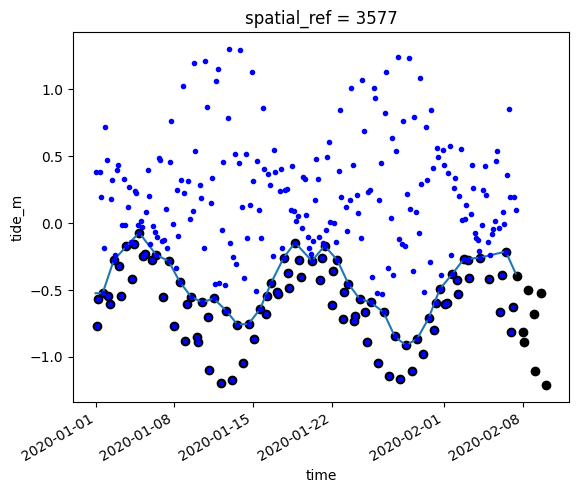

In [83]:

stacked_everything[0:300].plot(marker='.', linestyle='', color='blue', zorder=10)
low_peaks2[0:70].plot(linestyle='', color='orange')
highlow_peaks2[0:30].plot(linestyle='', color='g')
plt.plot(stacked_everything.time[0:300], high_low_linear[0:300])
lowtide[0:100].plot(marker='o', color='black', zorder=1, linestyle='')

In [85]:
# calculate all the low tide maxima
low_peaks = argrelmin(stacked_everything.values)[0]

# extract all lowtide peaks
low_peaks2 = stacked_everything.isel(time=low_peaks)

# identify all higher lowtide peaks
highlow_peaks = argrelmax(low_peaks2.values)[0]

# extract all higher lowtide peaks
highlow_peaks2 = low_peaks2.isel(time=highlow_peaks)

# interpolate the higher lowtide curve
high_low_linear = interp(np.arange(0,len(stacked_everything)),
                         low_peaks[highlow_peaks],
                         highlow_peaks2.values)
# Extract all tides lower than/equal to the extrapolated higher lowtide line
lowtide = stacked_everything.where(stacked_everything <= high_low_linear, drop=True)

## Save datetimes for calculation of combined filter exposure
timeranges['Lowtide'] = pd.to_datetime(lowtide.time)

tide_cq = lowtide.quantile(q=calculate_quantiles,dim='time').to_dataset()

In [91]:
tide_cq.to_dataset()

<xarray.Dataset>
Dimensions:   (quantile: 101)
Coordinates:
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
Data variables:
    tide_m    (quantile) float64 -1.306 -1.213 -1.189 ... 0.06157 0.2346

In [56]:
stacked_everything

<xarray.DataArray 'tide_m' (time: 8761)>
array([ 0.37810886, -0.768233  , -0.56757313, ..., -0.15731664,
        0.23607086,  0.22522296], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 ... 2022-12-31
    spatial_ref  int32 3577